In [1]:
#Loading Augmented Data
data_root = ("/content/drive/MyDrive/cow_augmntd")

In [2]:
#Defining Shape of the input image
IMAGE_SHAPE = (224, 224)

In [3]:
TRAINING_DATA_DIR = str(data_root)

In [4]:
#Setting Arguments for the data Generator
datagen_kwargs = dict(rescale=1./255, validation_split=.30)

In [5]:
#splitting the data into train and validation
import tensorflow as tf
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="validation",
shuffle=True,
target_size=IMAGE_SHAPE
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="training",
shuffle=True,
target_size=IMAGE_SHAPE)

Found 150 images belonging to 10 classes.
Found 366 images belonging to 10 classes.


In [7]:
for image_batch,label_batch in train_generator:
  break
 # print(image_batch.shape,label_batch.shape)

In [8]:
#Print the class indices
print (train_generator.class_indices)

{'cow0': 0, 'cow1': 1, 'cow2': 2, 'cow3': 3, 'cow4': 4, 'cow5': 5, 'cow6': 6, 'cow7': 7, 'cow8': 8, 'cow9': 9}


In [9]:
#Printing and saving class indices
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
 f.write(labels)
!cat labels.txt

cow0
cow1
cow2
cow3
cow4
cow5
cow6
cow7
cow8
cow9

In [10]:
#Using MobileNetV2 as feature extractor in Tensorflow
import tensorflow_hub as hub
model = tf.keras.Sequential([
 hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
 output_shape=[1280],
 trainable=False),
 tf.keras.layers.Dropout(0.4),
 #Adding final layer of classification
 tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
#Choosing Optimizer 
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(
 optimizer=optimizer,
 loss='categorical_crossentropy',
 metrics=['acc'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
train_generator.samples

366

In [13]:
import numpy as np
#Training the model
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
 train_generator, 
 epochs=5,
 verbose=1,
 steps_per_epoch=steps_per_epoch,
 validation_data=valid_generator,
 validation_steps=val_steps_per_epoch).history

Epoch 1/5
12/12 [==============================] - 210s 17s/step - loss: 2.3152 - acc: 0.2268 - val_loss: 1.2844 - val_acc: 0.7467
Epoch 2/5
12/12 [==============================] - 15s 1s/step - loss: 1.1553 - acc: 0.6257 - val_loss: 0.6685 - val_acc: 0.9533
Epoch 3/5
12/12 [==============================] - 18s 2s/step - loss: 0.6864 - acc: 0.8333 - val_loss: 0.3851 - val_acc: 0.9867
Epoch 4/5
12/12 [==============================] - 15s 1s/step - loss: 0.4361 - acc: 0.9098 - val_loss: 0.2482 - val_acc: 0.9867
Epoch 5/5
12/12 [==============================] - 15s 1s/step - loss: 0.2741 - acc: 0.9590 - val_loss: 0.1699 - val_acc: 0.9933


In [14]:
#Printing scores
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

5/5 [==============================] - 5s 856ms/step - loss: 0.1699 - acc: 0.9933
Final loss: 0.17
Final accuracy: 99.33%


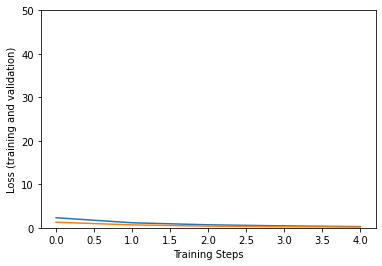

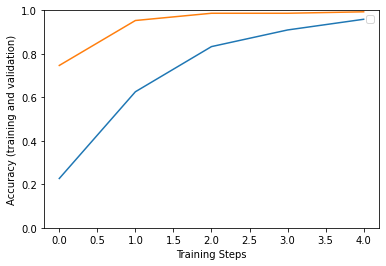

In [15]:
#Plotting the graph
import matplotlib.pyplot as plt
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,50])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.legend()

In [16]:
#Saving the model
model.save('cow.weights.best.hdf5')